# 1. CLIP

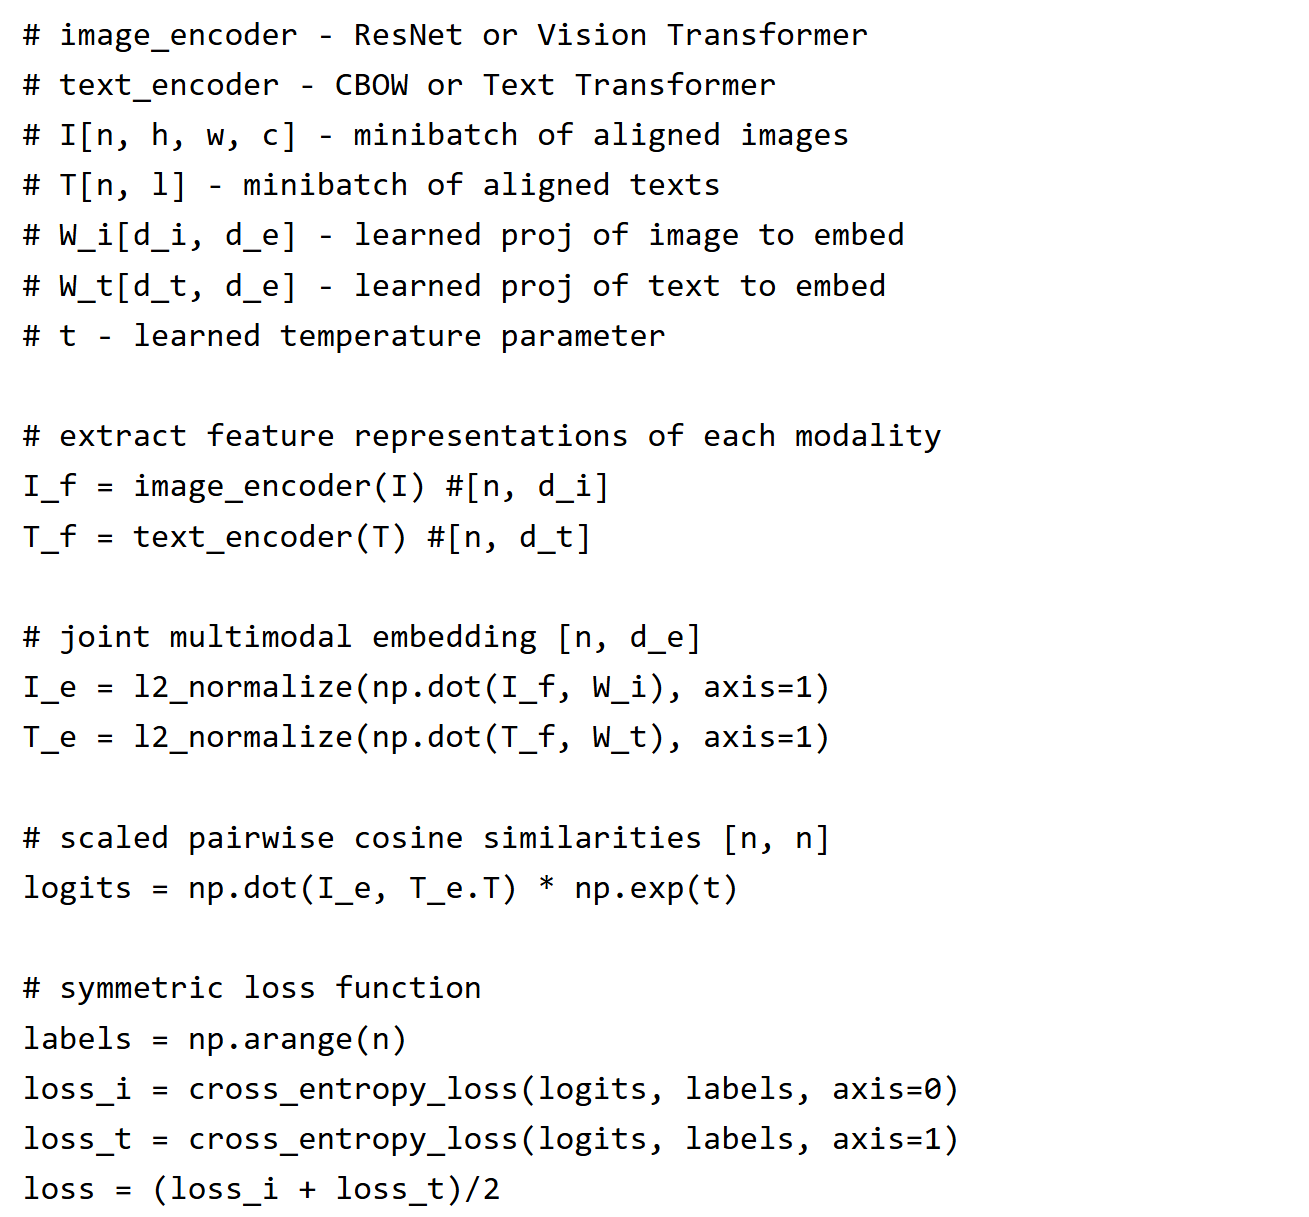

In [ ]:
# clip trained with (image, text) pair datasets which was huge
# Zero-shot performance that is competitive with supervised models: OCR, 비디오 동작 인식, 지리적 위치 파악, 그리고 다양한 유형의 세밀한 객체 분류와 같은 작업에 대해 성능 평가
# High zero shot performance on ImageNet

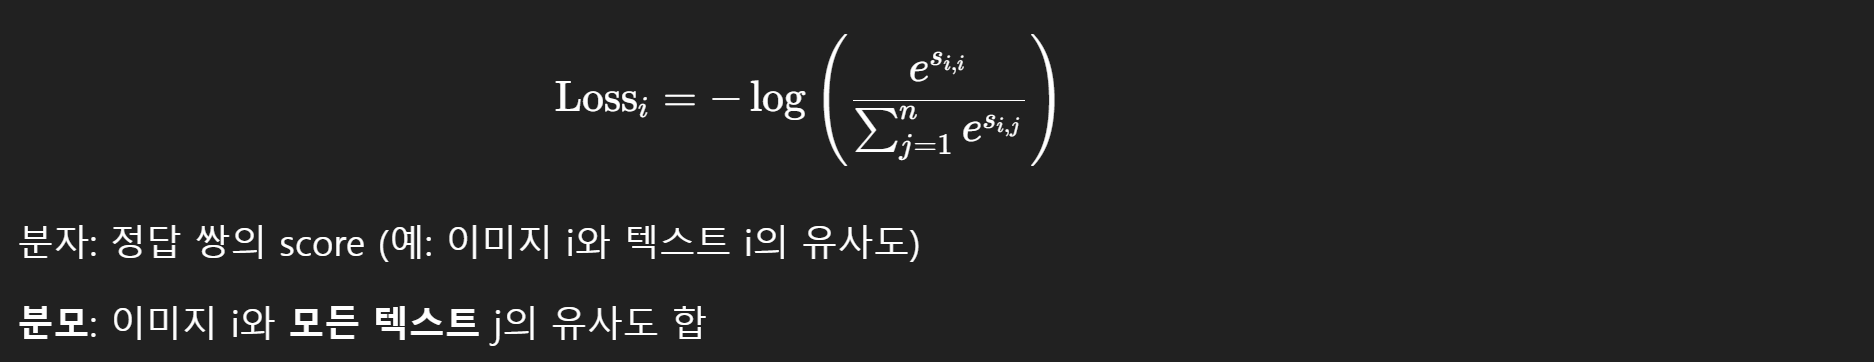

In [ ]:
# 다른 쌍을 멀리하는 역할도 같은 cross_entropy 안에 자연스럽게 포함되어 있다.
# 오답 쌍들의 유사도도 낮아야 분모 작아지고 true_prob도 커짐
# 이미지 중심으로 한번(axis=1), 텍스트 중심으로 한번(axis=0) 구해서 평균낸다. 총 loss는 n개 + n개 더하고 1/2한게 된다.

In [2]:
! pip install git+https://github.com/openai/CLIP.git
import torch
import torch.nn as nn
import clip
import timm

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wnh9red4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wnh9red4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# 8 images
x=torch.randn(8, 3, 244, 244) # 표준 정규분포에서 랜덤 샘플링,requires_grad=False가 default
visual_enc=timm.create_model('resnet50',num_classes=0) # trimm 라이브러리는 사전 정의된 다양한 CNN, ViT, Hybrid 모델들 불러옴
# 학습되는 텐서는 nn.Module 안에 들어있음
# 클립에선 텍스트, 비주얼 인코더 모두 재학습됨(nn.Parameters)
'''
timm에서 num_classes=0을 설정하면 classification head를 제거하고,
마지막 global pooling layer의 출력을 그대로 반환
softmax 직전 단계를 "출력"으로 사
'''
I_f=visual_enc(x)
n, d_i=I_f.shape
n, d_i

(8, 2048)

In [5]:
text_enc=nn.Embedding(100, 768) # 100개의 토큰에 대해 각각 768차원의 임베딩을 랜덤하게 초기화
"""
nn.Embedding은 내부적으로 학습 가능한 nn.Parameter를 만들며,
requires_grad=True인 상태로 학습이 진행
"""
T_f=text_enc(torch.arange(8)) # 임베딩 테이블 룩업/ 테스트용 더미 인덱스
n, d_t = T_f.shape
n, d_t
# 원래는
# 줄글 문장 전체를 토크나이즈 → 여러 개의 토큰 → 각각 임베딩 → transformer 통과 → 최종 벡터 추출
# Transformer과정에서 통째로 처리하고 → 1개의 대표 벡터로 압축됨 (예: [CLS] 위치 or 평균)
# 따라서 텍스트 임베딩 디멘션이 모두 같아질 수 있다.

(8, 768)

In [6]:
d_e=1024
W_i=nn.Linear(d_i, d_e)
W_t=nn.Linear(d_t, d_e)
W_i, W_t

(Linear(in_features=2048, out_features=1024, bias=True),
 Linear(in_features=768, out_features=1024, bias=True))

In [7]:
I_e=W_i(I_f)
T_e=W_t(T_f)
I_e.shape ,T_e.shape

(torch.Size([8, 1024]), torch.Size([8, 1024]))

In [8]:
logits= I_e @ T_e.T # [n, d], [n, d]니까 하나는 .T해야함 -> [n, n]
logits.shape

torch.Size([8, 8])

When we do cross entropy loss with both axis=1 and axis=0, we are pushing logits to be high for the diagonal and low everywhere else. This is also referred to as Contrastive Loss.

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn

class ClipLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def get_ground_truth(self, device, num_logits)-> torch.Tensor:
    labels=torch.arange(num_logits, device=device, dtype=torch.long)
    return labels

  def get_logits(self, image_features, text_features, logit_scale):
    logits_per_image=logit_scale*image_features @ text_features.T
    logits_per_text=logit_scale*image_features @ text_features.T
    return logits_per_image, logits_per_text

  def forward(self, image_features, text_features, logit_scale, output_dict=False):
    device=image_features.device
    logits_per_image, logits_per_text=self.get_logits(image_features,text_features, logit_scale)
    labels=self.get_ground_truth(device, logits_per_image.shape[0])
    total_loss=(
        F.cross_entropy(logits_per_image,labels)+
        F.cross_entropy(logits_per_text,labels)
    )/2
    return total_loss


In [12]:
loss_fn=ClipLoss()
logit_scale=nn.Parameter(torch.tensor(np.log(1/0.07))) # 학습 가능하게
loss=loss_fn(I_e,T_e,logit_scale)

# 2. Train

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from transformers import BertModel, BertTokenizer

EMBED_DIM = 512  # 공통 임베딩 차원

class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM):
        super().__init__()
        base_model = resnet18(pretrained=True)
        base_model.fc = nn.Identity()
        self.backbone = base_model
        self.proj = nn.Linear(512, embed_dim)

    def forward(self, x):
        x = self.backbone(x)           # [B, 512]
        x = self.proj(x)               # [B, embed_dim]
        return x
# 원래는 gpt계열 디코더를 텍스트인코딩에 사용
class TextEncoder(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.proj = nn.Linear(768, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0]  # [B, 768]
        return self.proj(cls)                  # [B, embed_dim]


class ClipLoss(nn.Module):
    def forward(self, image_features, text_features, logit_scale):
        device = image_features.device
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        logits_per_image = logit_scale * image_features @ text_features.T
        logits_per_text  = logit_scale * text_features @ image_features.T
        labels = torch.arange(image_features.shape[0], device=device)

        loss_i = F.cross_entropy(logits_per_image, labels)
        loss_t = F.cross_entropy(logits_per_text, labels)
        return (loss_i + loss_t) / 2


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random

class ImageTextDataset(Dataset): # Dataset: 전체 데이터셋 정의 (index 단위로 하나씩 반환)
    def __init__(self, image_paths, captions, transform=None):
        self.image_paths = image_paths
        self.captions = captions
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        caption = self.captions[idx]
        return image, caption

# 예시 이미지 경로와 텍스트
image_paths = ["./images/dog.jpg", "./images/cat.jpg", "./images/bird.jpg"]
captions = ["a photo of a dog", "a photo of a cat", "a photo of a bird"]

dataset = ImageTextDataset(image_paths, captions)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
# torch.utils.data.DataLoader: 미니 배치 단위로 Dataset을 묶어주는 반복자(Dataset을 배치만큼 반복호출)

In [14]:
image_encoder = ImageEncoder().cuda()
text_encoder = TextEncoder().cuda()
logit_scale = nn.Parameter(torch.tensor(np.log(1 / 0.07), dtype=torch.float32, device='cuda'))

loss_fn = ClipLoss()
optimizer = torch.optim.Adam(
    list(image_encoder.parameters()) +
    list(text_encoder.parameters()) +
    [logit_scale],
    lr=1e-4
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

for epoch in range(10):
    for images, texts in dataloader:  # dataloader는 (image_tensor, text_string) 튜플 반환해야 함
        images = images.cuda()
        tokens = tokenizer(texts, return_tensors='pt', padding=True, truncation=True).to('cuda')

        image_features = image_encoder(images)
        text_features  = text_encoder(tokens['input_ids'], tokens['attention_mask'])

        loss = loss_fn(image_features, text_features, logit_scale.exp())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
